**Task:** TensorFlow is an open-source machine learning framework developed by Google for the sole purpose of building and training machine learning models.

One of the datasets under the Tensorflow Image libraries is a malaria dataset which contains approximately 27,500 cell images of parasitized and uninfected cells from thin blood smear slide images of segmented cells.

Using this dataset, we would like you to create a model which is able to classify whether a blood smear is uninfected or parasitized.

In [ ]:
# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
# Load the malaria dataset
ds, ds_info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteP4IDTZ/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [4]:
# Convert the Tensorflow dataset to numpy array
ds_numpy = tfds.as_numpy(ds)

In [5]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# To change the input dataset
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((120,120)),
    transforms.ColorJitter(0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace=True)
])

In [6]:
# Convert dataset from numpy array to Pytorch tensor
class Conv(Dataset):
    def __init__(self, numpy_dataset, transform=None):
        self.data = list(numpy_dataset)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [13]:
pytorch_dataset = Conv(ds_numpy, transform=transform)

In [14]:
# Split dataset to train and test sets
test_size = 0.2

num_train = len(pytorch_dataset)
indices = list(range(num_train))

test_split = int(np.floor((test_size) * num_train))
test_index, train_index = indices[:test_split - 1], indices[test_split - 1:]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(pytorch_dataset, sampler=train_sampler, batch_size=128)
test_loader = DataLoader(pytorch_dataset, sampler=test_sampler, batch_size=64)
print("Images in the test set: {}\nImages in the train set: {}".format(len(test_index), len(train_index)))

Images in the test set: 5510
Images in the train set: 22048


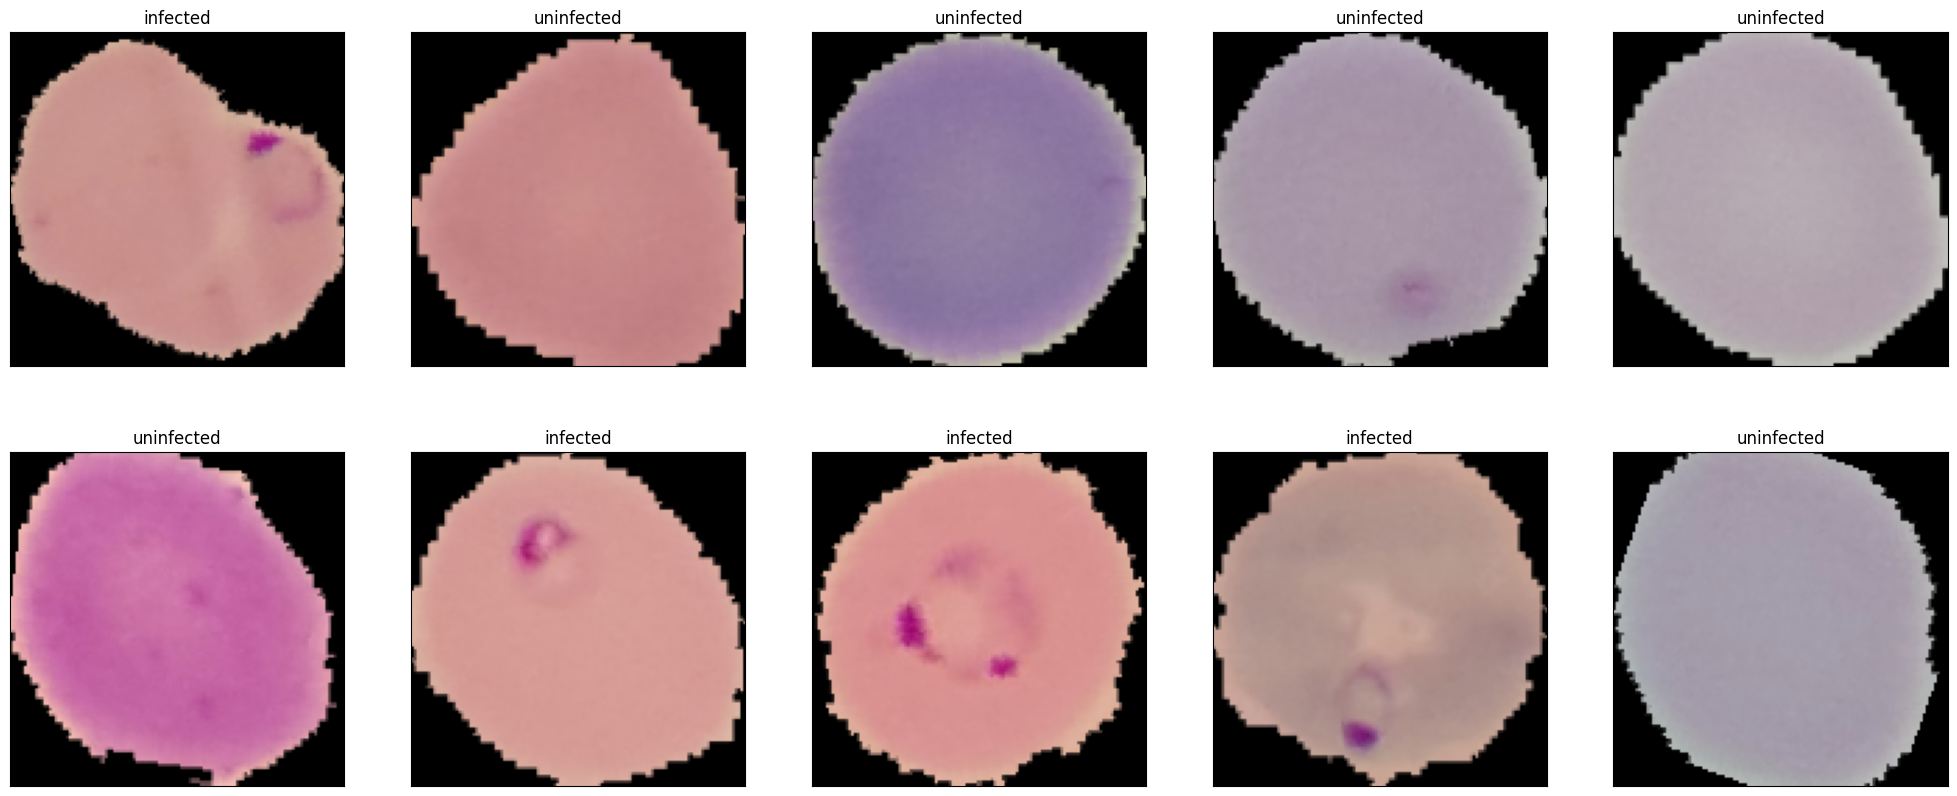

In [16]:
# Show sample classified images
def imshow(img):
    img = img / 2 + 0.5
    numpy_img = img.numpy()
    plt.imshow(np.transpose(numpy_img, (1, 2, 0)))

images, labels = next(iter(train_loader))
classes=['infected','uninfected']

fig = plt.figure(figsize=(25, 10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [18]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [19]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
# Function to calculate the model's accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
class MalariaDetection(nn.Module):
    def train_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [25]:
class Malaria(MalariaDetection):
    def __init__(self):
        super(Malaria, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.flatten(out)

        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)

        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)

        out = self.fc3(out)

        return out

In [26]:
model = Malaria()

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
to_device(model, device)

Malaria(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=14400, out_features=512, bias=True)
  (fc2

In [29]:
# Set training variables
learning_rate = 0.0001
optimizer = torch.optim.Adam
epochs = 20

In [30]:
@torch.no_grad()
# Evaluate the model
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [31]:
# Function to fit the dataset
def fit(epochs, lr, model, train_loader, val_loader, opt=torch.optim.SGD):
    training = []
    optimizer = opt(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        training.append(result)
    return training

In [32]:
model = to_device(Malaria(), device)


In [33]:
training = fit(epochs, learning_rate, model, train_loader, test_loader, opt=optimizer)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [0], train_loss: 0.5409, val_loss: 0.3565, val_acc: 0.8341
Epoch [1], train_loss: 0.2668, val_loss: 0.1726, val_acc: 0.9316
Epoch [2], train_loss: 0.1889, val_loss: 0.1427, val_acc: 0.9494
Epoch [3], train_loss: 0.1658, val_loss: 0.1324, val_acc: 0.9535
Epoch [4], train_loss: 0.1619, val_loss: 0.1394, val_acc: 0.9492
Epoch [5], train_loss: 0.1513, val_loss: 0.1366, val_acc: 0.9528
Epoch [6], train_loss: 0.1436, val_loss: 0.1172, val_acc: 0.9576
Epoch [7], train_loss: 0.1429, val_loss: 0.1279, val_acc: 0.9542
Epoch [8], train_loss: 0.1363, val_loss: 0.1252, val_acc: 0.9565
Epoch [9], train_loss: 0.1349, val_loss: 0.1195, val_acc: 0.9549
Epoch [10], train_loss: 0.1350, val_loss: 0.1241, val_acc: 0.9588
Epoch [11], train_loss: 0.1293, val_loss: 0.1163, val_acc: 0.9598
Epoch [12], train_loss: 0.1272, val_loss: 0.1120, val_acc: 0.9601
Epoch [13], train_loss: 0.1272, val_loss: 0.1191, val_acc: 0.9574
Epoch [14], train_loss: 0.1230, val_loss: 0.1077, val_acc: 0.9591
Epoch [15], train_lo